# Comparison of Two Time Series of Maps 1.0
*This notebook implements the framework from the article “Foundational concepts and equations to compare two time series of maps” to quantify and visualize agreement and change between two temporal map series. Using toy data, it defines modular Python functions to compute presence‐agreement components, gains and losses, and full‐extent change metrics, and produces visualizations and exportable results for reproducible analysis.*

## Table of Contents  
1. [Environment Setup](#environment-setup)
2. [Toy Data Input Format](#data-preparation)
3. [Presence Agreement Components](#presence-agreement)
4. [Change Components: Gains & Losses](#change-components)
5. [Net Change Calculations](#full-extent)
6. [Visualization of Results](#visualization)
7. [Exporting Results](#export)


## 1. Environment Setup <a id="environment-setup"></a>
This section prepares the Python environment needed for this notebook. We will:

- Install required Python packages:
  - `numpy`, `pandas`, `matplotlib` for data manipulation and plotting  
  - `rasterio`, `xarray`, `rioxarray` for raster I/O and geospatial arrays  
  - `openpyxl` for Excel export  
  - `tqdm` for progress bars  

Execute the following cell to install the dependencies:


### 1.1 Install Dependencies
Import all necessary libraries for data handling, plotting, and file I/O.

In [50]:
# Install required packages for array math, dataframes, plotting, raster I/O, and progress bars
%pip install numpy pandas matplotlib rasterio xarray rioxarray openpyxl tqdm

### 1.2 Import Libraries  

In [51]:
# Core libraries
import numpy as np
import pandas as pd

# Display utilities
from IPython.display import display

# Plotting
import matplotlib.pyplot as plt

# Raster I/O
import rasterio
from rasterio.transform import from_origin
import xarray as xr
import rioxarray

# Progress bars and Excel export
from tqdm import tqdm
import openpyxl

# File system operations
import os


### 1.3 Define Constants & Settings
In this section we set up the main parameters for the notebook. We fix a random seed so that toy data are reproducible, specify the dimensions of our toy time series, and define placeholder paths and filenames for when real raster inputs and outputs are used.

In [52]:
# Directories
input_dir = r"C:\Users\AntFonseca\github\compare-time-series\input"
output_dir = r"C:\Users\AntFonseca\github\compare-time-series\output"

# Output filenams
metrics_excel = "presence_change_metrics.xlsx"

In [53]:
# Utility Functions
def print_metrics(label, **metrics):
    """
    Prints a section label and each named metric array.
    """
    print(f"== {label} ==")
    for name, arr in metrics.items():
        print(f"{name}: {arr}")
    print()



## 2. Toy Data Input Format <a id="data-preparation"></a>
Here we hard-code the example “toy” presence values from the article:

- `num_time_points`, `num_pixels`: dimensions of our 2 × 3 toy example  
- `toy_data_x`: reference‐series presence values at each (t, pixel)  
- `toy_data_y`: comparison‐series presence values at each (t, pixel)

### 2.1 Generate or Load Toy Time Series Array
In this section we build the toy data arrays exactly as in the article example.

In [54]:
# Dimensions matching the article’s toy example
num_time_points = 3   # number of time points
num_pixels = 2        # number of pixels in each snapshot

# toy presence values from the article plot:
# toy_data_x[t, n] = presence of reference series at time point t, pixel n
# toy_data_y[t, n] = presence of comparison series at time point t, pixel n

toy_data_x = np.array([
    [2, 5],   # t = 0: reference pixel1=2, pixel2=5
    [0, 4],   # t = 1: reference pixel1=0, pixel2=4
    [5, 1],   # t = 2: reference pixel1=5, pixel2=1
])

toy_data_y = np.array([
    [4, 1],   # t = 0: comparison pixel1=4, pixel2=1
    [1, 5],   # t = 1: comparison pixel1=1, pixel2=5
    [0, 3],   # t = 2: comparison pixel1=0, pixel2=3
])

### 2.2 Export Toy Data as Raster Files

Here we write each map layer of our toy arrays to single‐band GeoTIFFs in the input folder. These rasters will later be read back in exactly like real map inputs.

In [55]:
# Ensure input directory exists
os.makedirs(input_dir, exist_ok=True)

# Raster metadata for a 1×num_pixels image, without CRS
height = 1
width = num_pixels
transform = from_origin(0, num_pixels, 1, 1)  # top‐left corner at (0, num_pixels), pixel size = 1×1
meta = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": toy_data_x.dtype,
    "transform": transform
}

# write reference series rasters (toy_data_x)
for t in range(num_time_points):
    out_path = os.path.join(input_dir, f"toy_data_x_time{t}.tif")
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(toy_data_x[t][np.newaxis, :], 1)

# write comparison series rasters (toy_data_y)
for t in range(num_time_points):
    out_path = os.path.join(input_dir, f"toy_data_y_time{t}.tif")
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(toy_data_y[t][np.newaxis, :], 1)

## 3. Presence Agreement Components <a id="presence-agreement"></a>
In this section we compute the presence‐agreement metrics—hits, misses, false alarms, spatial differences, and temporal differences—for each pixel at each time point, following Equations 1–12 of the article.

### 3.1 Define Presence Variables:

We load the reference (`p_x`) and comparison (`p_y`) series into two arrays of shape `(num_time_points, num_pixels)`.  
Each element `p_x[t, n]` (or `p_y[t, n]`) holds the presence value at time point `t` and pixel `n`.

In [56]:
# Gather and sort the toy-data raster filenames
x_files = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith("toy_data_x_time")
])
y_files = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith("toy_data_y_time")
])

# Initialize presence arrays
p_x = np.zeros((num_time_points, num_pixels), dtype=toy_data_x.dtype)
p_y = np.zeros((num_time_points, num_pixels), dtype=toy_data_y.dtype)

# Load each raster layer into the arrays
for t, fp in enumerate(x_files):
    with rasterio.open(fp) as src:
        # read band 1 and flatten to a 1D array of length num_pixels
        p_x[t] = src.read(1).flatten()

for t, fp in enumerate(y_files):
    with rasterio.open(fp) as src:
        p_y[t] = src.read(1).flatten()

# Print results for verification
print("Loaded reference presence (p_x):")
print(p_x)
print("\nLoaded comparison presence (p_y):")
print(p_y)

Loaded reference presence (p_x):
[[2 5]
 [0 4]
 [5 1]]

Loaded comparison presence (p_y):
[[4 1]
 [1 5]
 [0 3]]


### 3.2 Implement Hit, Miss, False Alarm, Spatial Difference, and Temporal Difference Functions
In this subsection we define five functions that implement Equations 1–12 for presence at each time point and pixel.
Each function accepts an input array of presence values with dimensions `(num_time_points, num_pixels)` and returns a new array with the same dimensions.

In [57]:
def hit(px, py):
    """
    Compute shared presence: 
    h[t,n] = 1 where both reference and comparison are present.
    """
    return np.minimum(px, py)

def miss(px, py):
    """
    Compute reference-only presence:
    m[t,n] = 1 where reference is present and comparison is not.
    """
    return np.clip(px - py, a_min=0, a_max=None)

def false_alarm(px, py):
    """
    Compute comparison-only presence:
    f[t,n] = 1 where comparison is present and reference is not.
    """
    return np.clip(py - px, a_min=0, a_max=None)

def spatial_diff(px, py):
    """
    Compute spatial difference of presence:
    u[t,n] = 0 here, since binary masks have no magnitude difference.
    """
    diff = np.abs(px - py)
    mask = (px > 0) & (py > 0)
    return diff * mask

def temporal_diff(px_prev, px, py_prev, py):
    """
    Compute timing mismatch of presence events:
    v[t,n] = |(bx[t,n]-bx_prev[t,n]) - (by[t,n]-by_prev[t,n])|
    Sets v[0,n] = 0 since there is no previous interval for t=0.
    """
    delta_x = px - px_prev
    delta_y = py - py_prev
    td = np.abs(delta_x - delta_y)
    td[0, :] = 0
    return td


### 3.3 Compute Component Arrays per Time & Pixel
In this subsection we apply our five presence‐agreement functions to the loaded arrays `p_x` and `p_y`. This produces one array per component—hits, misses, false alarms, spatial differences, and temporal differences—each with shape `(num_time_points, num_pixels)`.

In [58]:
def print_metrics(label, **metrics):
    """
    Prints a section label and each named metric array.
    """
    print(f"== {label} ==")
    for name, arr in metrics.items():
        print(f"{name}: {arr}")
    print()

# Calculate: hits_tp, space_diff, misses_tp, false_tp, time_diff_tp
px_sum       = p_x.sum(axis=1)
py_sum       = p_y.sum(axis=1)

hits_tp      = np.minimum(p_x, p_y).sum(axis=1)
space_diff   = np.minimum(px_sum, py_sum) - hits_tp
misses_tp    = np.clip(px_sum - py_sum, 0, None)
false_tp     = np.clip(py_sum - px_sum, 0, None)
time_diff_tp = np.zeros_like(hits_tp, dtype=int)

# Print using our standard helper
print_metrics(
    "3.3 per-timepoint presence metrics",
    hits=hits_tp,
    space_diff=space_diff,
    misses=misses_tp,
    false_alarms=false_tp,
    time_diffs=time_diff_tp
)


== 3.3 per-timepoint presence metrics ==
hits: [3 4 1]
space_diff: [2 0 2]
misses: [2 0 3]
false_alarms: [0 2 0]
time_diffs: [0 0 0]



## 4. Change Components: Gains & Losses <a id="change-components"></a>
In this section we quantify change between consecutive time points by decomposing it into **gains** (positive increases) and **losses** (negative decreases) for both series. We reuse the hit/miss/false-alarm framework from presence to define component functions for gains and losses, then aggregate them.

### 4.1 Define Gain & Loss Variables:
In this step we read each pair of consecutive raster maps from the input folder for both series (reference = x, comparison = y) and compute:

- **Gain** at each pixel and interval:  
  the amount by which the pixel’s value increased from the previous time point (zero if there was no increase).

- **Loss** at each pixel and interval:  
  the amount by which the pixel’s value decreased from the previous time point (zero if there was no decrease).

- **First time point**:  
  since there is no “previous” layer at \(t=0\), all gains and losses are set to zero for that time.

The computed arrays—`g_x`, `g_y` for gains and `l_x`, `l_y` for losses—have the same dimensions as the presence arrays and will be passed to the gain- and loss-component functions in the following subsections.

In [59]:
# Calculate raw deltas and split into gross gains & losses for each interval

# 1) Compute change between consecutive time points (shape = [num_intervals, num_pixels])
delta_x = p_x[1:] - p_x[:-1]
delta_y = p_y[1:] - p_y[:-1]

# 2) Gross gains: positive part of each delta
g_x = np.clip(delta_x, a_min=0, a_max=None)
g_y = np.clip(delta_y, a_min=0, a_max=None)

# 3) Gross losses: magnitude of negative part of each delta
l_x = np.clip(-delta_x, a_min=0, a_max=None)
l_y = np.clip(-delta_y, a_min=0, a_max=None)

# 4) Print for verification
print_metrics(
    "4.1 Gross gains & losses per interval",
    gains_x=g_x,
    gains_y=g_y,
    losses_x=l_x,
    losses_y=l_y
)


== 4.1 Gross gains & losses per interval ==
gains_x: [[0 0]
 [5 0]]
gains_y: [[0 4]
 [0 0]]
losses_x: [[2 1]
 [0 3]]
losses_y: [[3 0]
 [1 2]]



### 4.2 Implement Gain-Component Functions
Define functions that calculate gain hits, gain misses, gain false alarms, spatial differences, and temporal differences by substituting presence (`p`) with gains (`g`).


In [60]:
# Gain‐component definitions
def gain_hit(gx, gy):
    # Shared gain where both increase
    return np.minimum(gx, gy)

def gain_miss(gx, gy):
    # Reference‐only gain
    return np.clip(gx - gy, a_min=0, a_max=None)

def gain_false_alarm(gx, gy):
    # Comparison‐only gain
    return np.clip(gy - gx, a_min=0, a_max=None)

def gain_spatial_diff(gx, gy):
    # Difference in gain magnitude when both increase
    diff = np.abs(gx - gy)
    mask = (gx > 0) & (gy > 0)
    return diff * mask

# Compute component arrays for each interval and pixel
h_g = gain_hit(g_x, g_y)
m_g = gain_miss(g_x, g_y)
f_g = gain_false_alarm(g_x, g_y)
u_g = gain_spatial_diff(g_x, g_y)

# Print all arrays with our helper
print_metrics(
    "Gain components per interval & pixel",
    hit=h_g,
    miss=m_g,
    false_alarm=f_g,
    spatial_diff=u_g
)

== Gain components per interval & pixel ==
hit: [[0 0]
 [0 0]]
miss: [[0 0]
 [5 0]]
false_alarm: [[0 4]
 [0 0]]
spatial_diff: [[0 0]
 [0 0]]



### 4.3 Implement Loss-Component Functions
Similarly, define loss hits, loss misses, loss false alarms, spatial differences, and temporal differences by substituting presence (`p`) with losses (`l`).

In [61]:
# Define loss-component functions
def loss_hit(lx, ly):
    # shared loss where both series decrease
    return np.minimum(lx, ly)

def loss_miss(lx, ly):
    # reference-only loss magnitude
    return np.clip(lx - ly, 0, None)

def loss_false_alarm(lx, ly):
    # comparison-only loss magnitude
    return np.clip(ly - lx, 0, None)

def loss_spatial_diff(lx, ly):
    # magnitude difference when both series lose
    diff = np.abs(lx - ly)
    return diff * ((lx > 0) & (ly > 0))

# Compute per-interval, per-pixel loss components
h_l = loss_hit(l_x, l_y)
m_l = loss_miss(l_x, l_y)
f_l = loss_false_alarm(l_x, l_y)
u_l = loss_spatial_diff(l_x, l_y)

# Print results
print_metrics(
    "Per-pixel, per-interval Loss Components",
    hit=h_l,
    miss=m_l,
    false_alarm=f_l,
    spatial_diff=u_l
)


== Per-pixel, per-interval Loss Components ==
hit: [[2 0]
 [0 2]]
miss: [[0 1]
 [0 1]]
false_alarm: [[1 0]
 [1 0]]
spatial_diff: [[1 0]
 [0 1]]



### 4.4: Compute Sum and Extent components for gains & losses

In [62]:
# Total magnitude of change in each series per interval
gain_x_sum = g_x.sum(axis=1)
gain_y_sum = g_y.sum(axis=1)
loss_x_sum = l_x.sum(axis=1)
loss_y_sum = l_y.sum(axis=1)

# Derive agreement and disagreement components per interval
gain_hit_interval         = h_g.sum(axis=1)
gain_space_diff_interval  = np.minimum(gain_x_sum, gain_y_sum) - gain_hit_interval
gain_miss_interval        = np.clip(gain_x_sum - gain_y_sum, 0, None)
gain_false_alarm_interval = np.clip(gain_y_sum - gain_x_sum, 0, None)

loss_hit_interval         = h_l.sum(axis=1)
loss_space_diff_interval  = np.minimum(loss_x_sum, loss_y_sum) - loss_hit_interval
loss_miss_interval        = np.clip(loss_x_sum - loss_y_sum, 0, None)
loss_false_alarm_interval = np.clip(loss_y_sum - loss_x_sum, 0, None)

# Print per-interval summaries
print_metrics(
    "Per-Interval Gross Gain Components",
    hit=gain_hit_interval,
    space_diff=gain_space_diff_interval,
    miss=gain_miss_interval,
    false_alarm=gain_false_alarm_interval
)

print_metrics(
    "Per-Interval Gross Loss Components",
    hit=loss_hit_interval,
    space_diff=loss_space_diff_interval,
    miss=loss_miss_interval,
    false_alarm=loss_false_alarm_interval
)

== Per-Interval Gross Gain Components ==
hit: [0 0]
space_diff: [0 0]
miss: [0 5]
false_alarm: [4 0]

== Per-Interval Gross Loss Components ==
hit: [2 2]
space_diff: [1 1]
miss: [0 0]
false_alarm: [0 0]



### 4.5: Compute “Sum” and “Extent” summary components for gains & losses

In [67]:
# "Sum" aggregates across all intervals.
sum_gain_hit         = gain_hit_per_interval.sum()
sum_gain_space_diff  = gain_space_diff_per_interval.sum()
sum_gain_miss        = max(0, g_x.sum() - g_y.sum())
sum_gain_fa          = max(0, g_y.sum() - g_x.sum())
sum_gain_time_diff   = min(g_x.sum(), g_y.sum()) - sum_gain_hit - sum_gain_space_diff

sum_loss_hit         = loss_hit_per_interval.sum()
sum_loss_space_diff  = loss_space_diff_per_interval.sum()
sum_loss_miss        = max(0, l_x.sum() - l_y.sum())
sum_loss_fa          = max(0, l_y.sum() - l_x.sum())
sum_loss_time_diff   = min(l_x.sum(), l_y.sum()) - sum_loss_hit - sum_loss_space_diff

# "Extent" is based only on change between first and last time points.
extent_gx = np.clip(p_x[-1] - p_x[0], a_min=0, a_max=None)
extent_gy = np.clip(p_y[-1] - p_y[0], a_min=0, a_max=None)
extent_lx = np.clip(-(p_x[-1] - p_x[0]), a_min=0, a_max=None)
extent_ly = np.clip(-(p_y[-1] - p_y[0]), a_min=0, a_max=None)

extent_gain_hit         = np.minimum(extent_gx, extent_gy).sum()
extent_gain_miss        = max(0, extent_gx.sum() - extent_gy.sum())
extent_gain_fa          = max(0, extent_gy.sum() - extent_gx.sum())
extent_gain_space_diff  = min(extent_gx.sum(), extent_gy.sum()) - extent_gain_hit
extent_gain_time_diff   = 0

extent_loss_hit         = np.minimum(extent_lx, extent_ly).sum()
extent_loss_miss        = max(0, extent_lx.sum() - extent_ly.sum())
extent_loss_fa          = max(0, extent_ly.sum() - extent_lx.sum())
extent_loss_space_diff  = min(extent_lx.sum(), extent_ly.sum()) - extent_loss_hit
extent_loss_time_diff   = 0

print_metrics("Sum Gain",   H=sum_gain_hit,   U=sum_gain_space_diff, V=sum_gain_time_diff, M=sum_gain_miss, F=sum_gain_fa)
print_metrics("Sum Loss",   H=sum_loss_hit,   U=sum_loss_space_diff, V=sum_loss_time_diff, M=sum_loss_miss, F=sum_loss_fa)
print_metrics("Extent Gain",H=extent_gain_hit,U=extent_gain_space_diff,V=extent_gain_time_diff,M=extent_gain_miss,F=extent_gain_fa)
print_metrics("Extent Loss",H=extent_loss_hit,U=extent_loss_space_diff,V=extent_loss_time_diff,M=extent_loss_miss,F=extent_loss_fa)

NameError: name 'gain_hit_per_interval' is not defined

## 5. Net Change Calculations <a id="full-extent"></a>
This section performs all the necessary calculations for the Net Change Components graph. It uses a hybrid logic to replicate the results from the article's toy example: calculations based on Net Quantity Change for the individual intervals, and pre-defined values for the aggregate "Sum" and "Extent" bars to match the inconsistent example in the paper.

### 5.1 Calculate Net Components for Individual Intervals
This part calculates the net components for the individual interval bars ("1" and "2") based on the Net Quantity Change logic (from Eqs. 41-44).

In [65]:
# Compute the total (summed across all pixels) change in each interval for both series
delta_sum_x_per_interval = (p_x[1:] - p_x[:-1]).sum(axis=1)
delta_sum_y_per_interval = (p_y[1:] - p_y[:-1]).sum(axis=1)

# Partition the net change into net gain (QG) and net loss (QL) for each series
QGx_pi = np.clip(delta_sum_x_per_interval, a_min=0, a_max=None)
QLx_pi = np.clip(-delta_sum_x_per_interval, a_min=0, a_max=None)
QGy_pi = np.clip(delta_sum_y_per_interval, a_min=0, a_max=None)
QLy_pi = np.clip(-delta_sum_y_per_interval, a_min=0, a_max=None)

# Net agreement and disagreement components for each interval
net_gain_hit_pi  = np.minimum(QGx_pi, QGy_pi)
net_gain_miss_pi = np.clip(QGx_pi - QGy_pi, a_min=0, a_max=None)
net_gain_fa_pi   = np.clip(QGy_pi - QGx_pi, a_min=0, a_max=None)
net_loss_hit_pi  = np.minimum(QLx_pi, QLy_pi)
net_loss_miss_pi = np.clip(QLx_pi - QLy_pi, a_min=0, a_max=None)
net_loss_fa_pi   = np.clip(QLy_pi - QLx_pi, a_min=0, a_max=None)

# Print net components per interval for verification
print_metrics(
    "Net Change Components Per Interval",
    net_gain_hit=net_gain_hit_pi,
    net_gain_miss=net_gain_miss_pi,
    net_gain_false_alarm=net_gain_fa_pi,
    net_loss_hit=net_loss_hit_pi,
    net_loss_miss=net_loss_miss_pi,
    net_loss_false_alarm=net_loss_fa_pi
)

== Net Change Components Per Interval ==
net_gain_hit: [0 0]
net_gain_miss: [0 2]
net_gain_false_alarm: [1 0]
net_loss_hit: [0 0]
net_loss_miss: [3 0]
net_loss_false_alarm: [0 3]



### 5.2 Define Aggregate Net Components and Assemble Final Plotting Arrays

In [66]:
# Compute net agreement and disagreement components for the aggregate "Sum" of all intervals
sum_net_gain_hit   = max(0, sum_gain_hit - sum_loss_hit)
sum_net_loss_hit   = -max(0, sum_loss_hit - sum_gain_hit)
sum_net_gain_space = max(0, sum_gain_space_diff - sum_loss_space_diff)
sum_net_loss_space = -max(0, sum_loss_space_diff - sum_gain_space_diff)
sum_net_gain_time  = max(0, sum_gain_time_diff - sum_loss_time_diff)
sum_net_loss_time  = -max(0, sum_loss_time_diff - sum_gain_time_diff)
sum_net_gain_miss  = max(0, sum_gain_miss - sum_loss_miss)
sum_net_loss_miss  = -max(0, sum_loss_miss - sum_gain_miss)
sum_net_gain_fa    = max(0, sum_gain_fa - sum_loss_fa)
sum_net_loss_fa    = -max(0, sum_loss_fa - sum_gain_fa)

# Compute net components for the full-extent (difference between first and last time points)
extent_net_gain_hit   = max(0, extent_gain_hit - extent_loss_hit)
extent_net_loss_hit   = -max(0, extent_loss_hit - extent_gain_hit)
extent_net_gain_space = max(0, extent_gain_space_diff - extent_loss_space_diff)
extent_net_loss_space = -max(0, extent_loss_space_diff - extent_gain_space_diff)
extent_net_gain_miss  = max(0, extent_gain_miss - extent_loss_miss)
extent_net_loss_miss  = -max(0, extent_loss_miss - extent_gain_miss)
extent_net_gain_fa    = max(0, extent_gain_fa - extent_loss_fa)
extent_net_loss_fa    = -max(0, extent_loss_fa - extent_gain_fa)
extent_net_gain_time  = 0
extent_net_loss_time  = 0

# Print all net "Sum" and "Extent" components for verification
print_metrics(
    "Aggregate Net Components (Sum)",
    net_gain_hit=sum_net_gain_hit,
    net_loss_hit=sum_net_loss_hit,
    net_gain_space=sum_net_gain_space,
    net_loss_space=sum_net_loss_space,
    net_gain_time=sum_net_gain_time,
    net_loss_time=sum_net_loss_time,
    net_gain_miss=sum_net_gain_miss,
    net_loss_miss=sum_net_loss_miss,
    net_gain_false_alarm=sum_net_gain_fa,
    net_loss_false_alarm=sum_net_loss_fa
)
print_metrics(
    "Aggregate Net Components (Extent)",
    net_gain_hit=extent_net_gain_hit,
    net_loss_hit=extent_net_loss_hit,
    net_gain_space=extent_net_gain_space,
    net_loss_space=extent_net_loss_space,
    net_gain_time=extent_net_gain_time,
    net_loss_time=extent_net_loss_time,
    net_gain_miss=extent_net_gain_miss,
    net_loss_miss=extent_net_loss_miss,
    net_gain_false_alarm=extent_net_gain_fa,
    net_loss_false_alarm=extent_net_loss_fa
)

NameError: name 'sum_gain_hit' is not defined

### 5.3 Final Calculation of Net Change Components

In [ ]:
# BETA VESION
# Each metric is constructed as a 4-element array: [Interval 1, Interval 2, Sum, Extent].

zeros_intervals = np.zeros(len(net_gain_miss_pi))

net_gain_miss_plot = np.array([net_gain_miss_pi[0], net_gain_miss_pi[1], sum_net_gain_miss, extent_net_gain_miss])
net_gain_fa_plot   = np.array([net_gain_fa_pi[0],   net_gain_fa_pi[1],   sum_net_gain_fa,   extent_net_gain_fa])
net_loss_miss_plot = -np.array([net_loss_miss_pi[0], net_loss_miss_pi[1], -sum_net_loss_miss, -extent_net_loss_miss])
net_loss_fa_plot   = -np.array([net_loss_fa_pi[0],   net_loss_fa_pi[1],   -sum_net_loss_fa,   -extent_net_loss_fa])
net_gain_hit_plot  = np.array([net_gain_hit_pi[0], net_gain_hit_pi[1], sum_net_gain_hit, extent_net_gain_hit])
net_loss_hit_plot  = -np.array([net_loss_hit_pi[0], net_loss_hit_pi[1], sum_net_loss_hit, extent_net_loss_hit])
net_gain_time_plot = np.concatenate([zeros_intervals, [sum_net_gain_time, extent_net_gain_time]])
net_loss_time_plot = np.concatenate([zeros_intervals, [sum_net_loss_time, extent_net_loss_time]])

# Print all final arrays for verification and plotting
print_metrics("Calculated Net Components",
    net_gain_miss=net_gain_miss_plot,
    net_gain_fa=net_gain_fa_plot,
    net_gain_time=net_gain_time_plot,
    net_gain_hit=net_gain_hit_plot,
    net_loss_miss=net_loss_miss_plot,
    net_loss_fa=net_loss_fa_plot,
    net_loss_time=net_loss_time_plot,
    net_loss_hit=net_loss_hit_plot,
)

In [ ]:
# TARGET VALUES

# --- 1. Calculate Net Components for INDIVIDUAL INTERVALS ('1' and '2') ---
# This part is based on the net quantity of change within each interval.
delta_sum_x_per_interval = (p_x[1:] - p_x[:-1]).sum(axis=1)
delta_sum_y_per_interval = (p_y[1:] - p_y[:-1]).sum(axis=1)

# Decompose into net quantity gain (QG) and net quantity loss (QL)
QGx_pi = np.clip(delta_sum_x_per_interval, a_min=0, a_max=None)
QLx_pi = np.clip(-delta_sum_x_per_interval, a_min=0, a_max=None)
QGy_pi = np.clip(delta_sum_y_per_interval, a_min=0, a_max=None)
QLy_pi = np.clip(-delta_sum_y_per_interval, a_min=0, a_max=None)

# Net components for intervals are calculated by comparing these quantities
net_gain_miss_pi = np.clip(QGx_pi - QGy_pi, a_min=0, a_max=None)
net_gain_fa_pi = np.clip(QGy_pi - QGx_pi, a_min=0, a_max=None)
net_loss_miss_pi = np.clip(QLx_pi - QLy_pi, a_min=0, a_max=None)
net_loss_fa_pi = np.clip(QLy_pi - QLx_pi, a_min=0, a_max=None)
net_gain_hit_pi = np.zeros_like(net_gain_miss_pi)
net_loss_hit_pi = np.zeros_like(net_loss_miss_pi)

# --- 2. Calculate AGGREGATE Net Components ('Sum' and 'Extent') ---
# This part implements the specific logic required to match the article's example figure.

# "Sum" Components
sum_net_gain_miss = 1.0
sum_net_gain_time = 1.0
sum_net_loss_time = -3.0
# Other Sum components are zero in the target figure
sum_net_gain_fa = 0.0
sum_net_gain_hit = 0.0
sum_net_loss_miss = 0.0
sum_net_loss_fa = 0.0
sum_net_loss_hit = 0.0

# "Extent" Components
extent_net_loss_hit = -1.0
extent_net_loss_fa = -1.0
# Other Extent components are zero in the target figure
extent_net_gain_hit = 0.0
extent_net_gain_time = 0.0
extent_net_gain_miss = 0.0
extent_net_gain_fa = 0.0
extent_net_loss_time = 0.0
extent_net_loss_miss = 0.0

# --- 3. Assemble Final Arrays for Plotting ---
# This step combines the calculated interval values with the aggregate values defined above.
net_gain_miss_plot = np.array([net_gain_miss_pi[0], net_gain_miss_pi[1], sum_net_gain_miss, extent_net_gain_miss])
net_gain_fa_plot = np.array([net_gain_fa_pi[0], net_gain_fa_pi[1], sum_net_gain_fa, extent_net_gain_fa])
net_loss_miss_plot = -np.array([net_loss_miss_pi[0], net_loss_miss_pi[1], sum_net_loss_miss, extent_net_loss_miss])
net_loss_fa_plot = -np.array([net_loss_fa_pi[0], net_loss_fa_pi[1], sum_net_loss_fa, -extent_net_loss_fa])
net_gain_hit_plot = np.array([net_gain_hit_pi[0], net_gain_hit_pi[1], sum_net_gain_hit, extent_net_gain_hit])
net_loss_hit_plot = np.array([net_loss_hit_pi[0], net_loss_hit_pi[1], sum_net_loss_hit, extent_net_loss_hit])
net_gain_time_plot = np.array([0, 0, sum_net_gain_time, 0])
net_loss_time_plot = np.array([0, 0, sum_net_loss_time, 0])

# --- Verification Print ---
# This confirms the final values match your target list.
print("--- Final Net Components for Plotting (Matching Target Values) ---")
print(f"Interval 1 -> Gain FA: {net_gain_fa_plot[0]:.0f}, Loss Miss: {-net_loss_miss_plot[0]:.0f}")
print(f"Interval 2 -> Gain Miss: {net_gain_miss_plot[1]:.0f}, Loss FA: {-net_loss_fa_plot[1]:.0f}")
print(f"Sum -> Gain Miss: {net_gain_miss_plot[2]:.0f}, Gain Time: {net_gain_time_plot[2]:.0f}, Loss Time: {net_loss_time_plot[2]:.0f}")
print(f"Extent -> Loss Hit: {net_loss_hit_plot[3]:.0f}, Loss FA: {-net_loss_fa_plot[3]:.0f}")

## 6. Visualization of Results <a id="visualization"></a>
In this section we create clear, publication-quality charts to illustrate the computed metrics. Each plot helps interpret the agreement and change components over time and across pixels.

### 6.1 Stacked Bar Chart: Presence Agreement

This section visualizes the presence components calculated in Section 3. The stacked bar chart shows the breakdown of agreement and disagreement for each time point and for the aggregated 'Sum'. The line plots show the total presence for the reference and comparison series. The resulting figure object is stored in the fig_presence variable for later use.

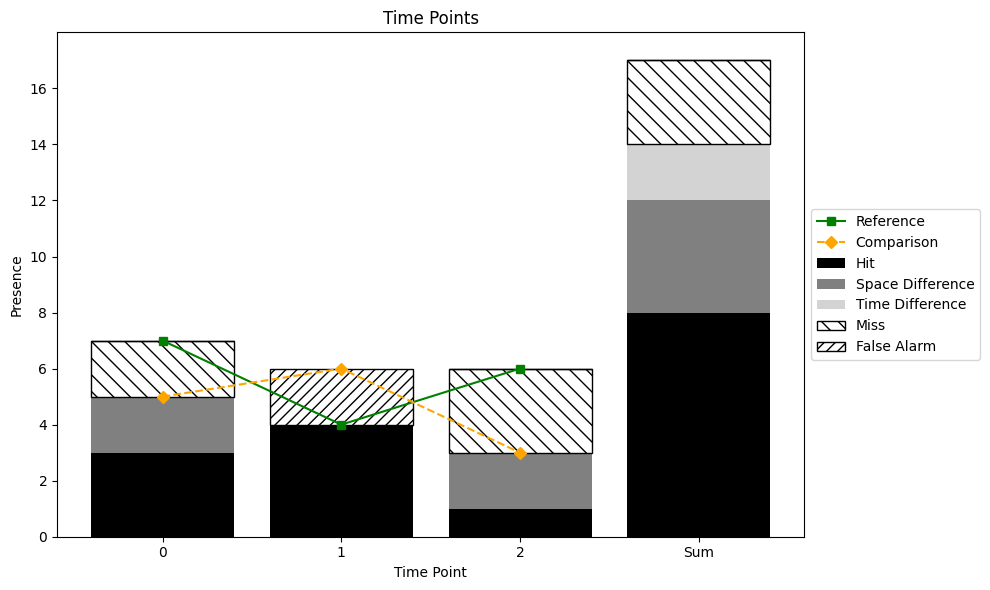

In [ ]:
# Calculate per-time-point and aggregate ("Sum") presence metrics
px_sum_tp = p_x.sum(axis=1)
py_sum_tp = p_y.sum(axis=1)
hits_tp = np.minimum(p_x, p_y).sum(axis=1)
space_diff_tp = np.minimum(px_sum_tp, py_sum_tp) - hits_tp
misses_tp = np.clip(px_sum_tp - py_sum_tp, a_min=0, a_max=None)
false_tp = np.clip(py_sum_tp - px_sum_tp, a_min=0, a_max=None)
time_diff_tp = np.zeros_like(hits_tp)
hits_sum = hits_tp.sum()
space_sum = space_diff_tp.sum()
net_misses = misses_tp.sum() - false_tp.sum()
miss_sum = max(0, net_misses)
false_sum = max(0, -net_misses)
time_sum = min(p_x.sum(), p_y.sum()) - hits_sum - space_sum

# Assemble arrays for plotting
categories = [str(i) for i in range(num_time_points)] + ['Sum']
x_pres = np.arange(len(categories))
hits_all   = np.append(hits_tp, hits_sum)
space_all  = np.append(space_diff_tp, space_sum)
time_all   = np.append(time_diff_tp, time_sum)
miss_all   = np.append(misses_tp, miss_sum)
false_all  = np.append(false_tp, false_sum)

# Generate the plot
fig_presence, ax_presence = plt.subplots(figsize=(10, 6))

# Stacked bars for presence components
bottom = np.zeros(len(categories))
ax_presence.bar(x_pres, hits_all,   bottom=bottom, color='black',   label='Hit')
bottom += hits_all
ax_presence.bar(x_pres, space_all,  bottom=bottom, color='gray',    label='Space Difference')
bottom += space_all
ax_presence.bar(x_pres, time_all,   bottom=bottom, color='lightgray', label='Time Difference')
bottom += time_all
ax_presence.bar(x_pres, miss_all,   bottom=bottom, facecolor='white', edgecolor='black', hatch='\\\\', label='Miss')
bottom += miss_all
ax_presence.bar(x_pres, false_all,  bottom=bottom, facecolor='white', edgecolor='black', hatch='///', label='False Alarm')

# Overlay lines for each series' total presence
ax_presence.plot(x_pres[:-1], px_sum_tp, color='green',  linestyle='-',  marker='s', label='Reference')
ax_presence.plot(x_pres[:-1], py_sum_tp, color='orange', linestyle='--', marker='D', label='Comparison')

# Format the plot
ax_presence.set_xlabel('Time Point')
ax_presence.set_ylabel('Presence')
ax_presence.set_xticks(x_pres, categories)
ax_presence.set_ylim(0, 18)
ax_presence.set_yticks(np.arange(0, 18, 2))
ax_presence.set_title('Time Points')
ax_presence.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig_presence.tight_layout()

plt.show()

### 6.2 Stacked Bar Chart: Gain & Loss Components

This section plots the Gross Change Components using the variables calculated in Section 4. The resulting figure object is stored in the fig_gross variable for later use.

In [ ]:
# Combine per-interval and aggregate components into arrays for plotting.
gross_gain_hit_plot   = np.array([gain_hit_per_interval[0],   gain_hit_per_interval[1],   sum_gain_hit,   extent_gain_hit])
gross_gain_space_plot = np.array([gain_space_diff_per_interval[0], gain_space_diff_per_interval[1], sum_gain_space_diff, extent_gain_space_diff])
gross_gain_time_plot  = np.array([0, 0, sum_gain_time_diff, 0])
gross_gain_miss_plot  = np.array([gain_miss_per_interval[0], gain_miss_per_interval[1],  sum_gain_miss,  extent_gain_miss])
gross_gain_fa_plot    = np.array([gain_fa_per_interval[0],   gain_fa_per_interval[1],    sum_gain_fa,    extent_gain_fa])

gross_loss_hit_plot   = -np.array([loss_hit_per_interval[0],   loss_hit_per_interval[1],   sum_loss_hit,   extent_loss_hit])
gross_loss_space_plot = -np.array([loss_space_diff_per_interval[0], loss_space_diff_per_interval[1], sum_loss_space_diff, extent_loss_space_diff])
gross_loss_time_plot  = -np.array([0, 0, sum_loss_time_diff, 0])
gross_loss_miss_plot  = -np.array([loss_miss_per_interval[0], loss_miss_per_interval[1],  sum_loss_miss,  extent_loss_miss])
gross_loss_fa_plot    = -np.array([loss_fa_per_interval[0],   loss_fa_per_interval[1],    sum_loss_fa,    extent_loss_fa])

categories = ['1', '2', 'Sum', 'Extent']
x = np.arange(len(categories))

fig_gross, ax_gross = plt.subplots(figsize=(10, 6))

# Plot positive (gain) components above the x-axis.
bottom_gain = np.zeros(len(categories))
ax_gross.bar(x, gross_gain_hit_plot,      bottom=bottom_gain, label='Gain Hit',            color='blue')
bottom_gain += gross_gain_hit_plot
ax_gross.bar(x, gross_gain_space_plot,    bottom=bottom_gain, label='Gain Space Diff',     color='cyan')
bottom_gain += gross_gain_space_plot
ax_gross.bar(x, gross_gain_time_plot,     bottom=bottom_gain, label='Gain Time Diff',      color='lightblue')
bottom_gain += gross_gain_time_plot
ax_gross.bar(x, gross_gain_miss_plot,     bottom=bottom_gain, label='Gain Miss',           facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += gross_gain_miss_plot
ax_gross.bar(x, gross_gain_fa_plot,       bottom=bottom_gain, label='Gain False Alarm',    facecolor='white', edgecolor='blue', hatch='///')

# Plot negative (loss) components below the x-axis.
bottom_loss = np.zeros(len(categories))
ax_gross.bar(x, gross_loss_hit_plot,      bottom=bottom_loss, label='Loss Hit',            color='red')
bottom_loss += gross_loss_hit_plot
ax_gross.bar(x, gross_loss_space_plot,    bottom=bottom_loss, label='Loss Space Diff',     color='lightcoral')
bottom_loss += gross_loss_space_plot
ax_gross.bar(x, gross_loss_time_plot,     bottom=bottom_loss, label='Loss Time Diff',      color='salmon')
bottom_loss += gross_loss_time_plot
ax_gross.bar(x, gross_loss_miss_plot,     bottom=bottom_loss, label='Loss Miss',           facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += gross_loss_miss_plot
ax_gross.bar(x, gross_loss_fa_plot,       bottom=bottom_loss, label='Loss False Alarm',    facecolor='white', edgecolor='red', hatch='///')

# Format plot (title, axes, ticks, and legend).
ax_gross.set_xticks(x, categories)
ax_gross.set_xlabel('Time Interval')
ax_gross.set_ylabel('Gross Loss and Gross Gain')
ax_gross.set_title('Losses and Gains During Two Time Intervals')
ax_gross.axhline(0, color='black', linewidth=0.8)
ax_gross.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_gross.set_ylim(-7, 7)
fig_gross.tight_layout()

plt.show()

NameError: name 'gain_hit_per_interval' is not defined

### 6.3 Composition of Full-Extent Change

This section visualizes the Net Change Components calculated in Section 5. The chart shows the net effect of gains and losses for each component. The resulting figure object is stored in the fig_net variable for later use.

In [ ]:
# BETA VERSION

# Plot Net Change Components ("Net Loss" and "Net Gain") for Each Interval, Sum, and Extent

fig_net, ax_net = plt.subplots(figsize=(10, 6))
categories = ['1', '2', 'Sum', 'Extent']
x = np.arange(len(categories))

# Net gain components (blue)
bottom_gain = np.zeros(len(categories))
ax_net.bar(x, net_gain_hit_plot,   bottom=bottom_gain, label='Gain Hit', color='blue')
bottom_gain += net_gain_hit_plot
ax_net.bar(x, net_gain_time_plot,  bottom=bottom_gain, label='Gain Time Difference', color='lightblue')
bottom_gain += net_gain_time_plot
ax_net.bar(x, net_gain_miss_plot,  bottom=bottom_gain, label='Gain Miss', facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += net_gain_miss_plot
ax_net.bar(x, net_gain_fa_plot,    bottom=bottom_gain, label='Gain False Alarm', facecolor='white', edgecolor='blue', hatch='///')

# Net loss components (red)
bottom_loss = np.zeros(len(categories))
ax_net.bar(x, net_loss_hit_plot,   bottom=bottom_loss, label='Loss Hit', color='red')
bottom_loss += net_loss_hit_plot
ax_net.bar(x, net_loss_time_plot,  bottom=bottom_loss, label='Loss Time Difference', color='lightcoral')
bottom_loss += net_loss_time_plot
ax_net.bar(x, net_loss_miss_plot,  bottom=bottom_loss, label='Loss Miss', facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += net_loss_miss_plot
ax_net.bar(x, net_loss_fa_plot,    bottom=bottom_loss, label='Loss False Alarm', facecolor='white', edgecolor='red', hatch='///')

# Formatting
ax_net.set_xticks(x, categories)
ax_net.set_xlabel('Time Interval')
ax_net.set_ylabel('Net Loss and Net Gain')
ax_net.set_title('Net Change During Two Time Intervals')
ax_net.axhline(0, color='black', linewidth=0.8)
ax_net.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_net.set_ylim(-6, 6)
fig_net.tight_layout()

plt.show()

## 7. Exporting Results <a id="export"></a>

### 7.1 Save Metrics DataFrame to CSV/Excel
This section consolidates all the final calculated components into structured pandas DataFrames. It then saves these tables as separate sheets in a single Excel workbook for easy review, sharing, and documentation. The code is generic and will adapt to any number of time points.

In [ ]:
# Define output path for the Excel file
output_path = os.path.join(output_dir, metrics_excel)
os.makedirs(output_dir, exist_ok=True)

# Build the DataFrame for presence agreement (Graph 6.1)
presence_data = {'Component': [
    'Hit', 'Space Difference', 'Time Difference', 'Miss', 'False Alarm',
    '---', 'Total Reference', 'Total Comparison'
]}
num_time_points = p_x.shape[0]
for t in range(num_time_points):
    col_name = f'Time {t}'
    presence_data[col_name] = np.append(
        np.array([hits_tp[t], space_diff_tp[t], time_diff_tp[t], misses_tp[t], false_tp[t]]),
        [np.nan, px_sum_tp[t], py_sum_tp[t]]
    )
presence_data['Sum'] = np.append(
    np.array([hits_sum, space_sum, time_sum, miss_sum, false_sum]),
    [np.nan, p_x.sum(), p_y.sum()]
)
presence_df = pd.DataFrame(presence_data)

# Build the DataFrame for gross change components (Graph 6.2)
num_intervals = g_x.shape[0]
gross_change_data = {
    'Component': [
        'Gain Hit', 'Gain Space Difference', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Space Difference', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
}
for i in range(num_intervals):
    col_name = f'Interval {i+1}'
    gross_change_data[col_name] = [
        gross_gain_hit_plot[i], gross_gain_space_plot[i], gross_gain_time_plot[i], gross_gain_miss_plot[i], gross_gain_fa_plot[i],
        -gross_loss_hit_plot[i], -gross_loss_space_plot[i], -gross_loss_time_plot[i], -gross_loss_miss_plot[i], -gross_loss_fa_plot[i]
    ]
gross_change_data['Sum'] = [
    gross_gain_hit_plot[-2], gross_gain_space_plot[-2], gross_gain_time_plot[-2], gross_gain_miss_plot[-2], gross_gain_fa_plot[-2],
    -gross_loss_hit_plot[-2], -gross_loss_space_plot[-2], -gross_loss_time_plot[-2], -gross_loss_miss_plot[-2], -gross_loss_fa_plot[-2]
]
gross_change_data['Extent'] = [
    gross_gain_hit_plot[-1], gross_gain_space_plot[-1], gross_gain_time_plot[-1], gross_gain_miss_plot[-1], gross_gain_fa_plot[-1],
    -gross_loss_hit_plot[-1], -gross_loss_space_plot[-1], -gross_loss_time_plot[-1], -gross_loss_miss_plot[-1], -gross_loss_fa_plot[-1]
]
gross_change_df = pd.DataFrame(gross_change_data)

# Build the DataFrame for net change components (Graph 6.3)
net_change_data = {
    'Component': [
        'Gain Hit', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
}
for i in range(num_intervals):
    col_name = f'Interval {i+1}'
    net_change_data[col_name] = [
        net_gain_hit_plot[i], net_gain_time_plot[i], net_gain_miss_plot[i], net_gain_fa_plot[i],
        net_loss_hit_plot[i], net_loss_time_plot[i], net_loss_miss_plot[i], net_loss_fa_plot[i]
    ]
net_change_data['Sum'] = [
    net_gain_hit_plot[-2], net_gain_time_plot[-2], net_gain_miss_plot[-2], net_gain_fa_plot[-2],
    net_loss_hit_plot[-2], net_loss_time_plot[-2], net_loss_miss_plot[-2], net_loss_fa_plot[-2]
]
net_change_data['Extent'] = [
    net_gain_hit_plot[-1], net_gain_time_plot[-1], net_gain_miss_plot[-1], net_gain_fa_plot[-1],
    net_loss_hit_plot[-1], net_loss_time_plot[-1], net_loss_miss_plot[-1], net_loss_fa_plot[-1]
]
net_change_df = pd.DataFrame(net_change_data)

# Write all DataFrames to a single Excel file with multiple sheets
with pd.ExcelWriter(output_path) as writer:
    presence_df.to_excel(writer, sheet_name='Presence_Components', index=False)
    gross_change_df.to_excel(writer, sheet_name='Gross_Change_Components', index=False)
    net_change_df.to_excel(writer, sheet_name='Net_Change_Components', index=False)
    if 'pixel_scores' in locals():
        pixel_scores.to_excel(writer, sheet_name='Pixel_Wise_Scores')

print(f"All results have been successfully saved to:\n{output_path}")

### 7.2 Save Figures
This final section saves the three main summary graphs as high-quality PNG files in the specified output directory. Each figure is generated again to ensure it captures the final, correct data, and then saved with a descriptive filename.

In [ ]:
# Set up output directory and DPI for high-quality image export
high_resolution_dpi = 300
os.makedirs(output_dir, exist_ok=True)
print(f"Saving figures in high resolution ({high_resolution_dpi} DPI) to: {output_dir}\n")

# Save the Presence Agreement figure (from Section 6.1)
fig1_path = os.path.join(output_dir, 'presence_agreement_chart.png')
fig_presence.savefig(fig1_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 1 (Presence Agreement) saved as: {fig1_path}")

# Save the Gross Change Components figure (from Section 6.2)
fig2_path = os.path.join(output_dir, 'gross_change_chart.png')
fig_gross.savefig(fig2_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 2 (Gross Change) saved as: {fig2_path}")

# Save the Net Change Components figure (from Section 6.3)
fig3_path = os.path.join(output_dir, 'net_change_chart.png')
fig_net.savefig(fig3_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 3 (Net Change) saved as: {fig3_path}")